This notebook shows the development of functions used to visualize the circulation during upwelling events.

In [1]:
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
from matplotlib.dates import DateFormatter
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot
import functions_profiles

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

In [2]:
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
bathy = bathy_file['Bathymetry']

coord_lats = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_02.nc')['nav_lat'][:]

path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/upwelling_events/'; cfg = 'eventB_1'
grid, lon, lat, tem, sal, ssh, U, V, W, tmask = functions_plot.load_model_output(path, cfg)
utau, vtau = functions_plot.load_model_other(path, cfg)
depth_levels = grid['deptht'][:]

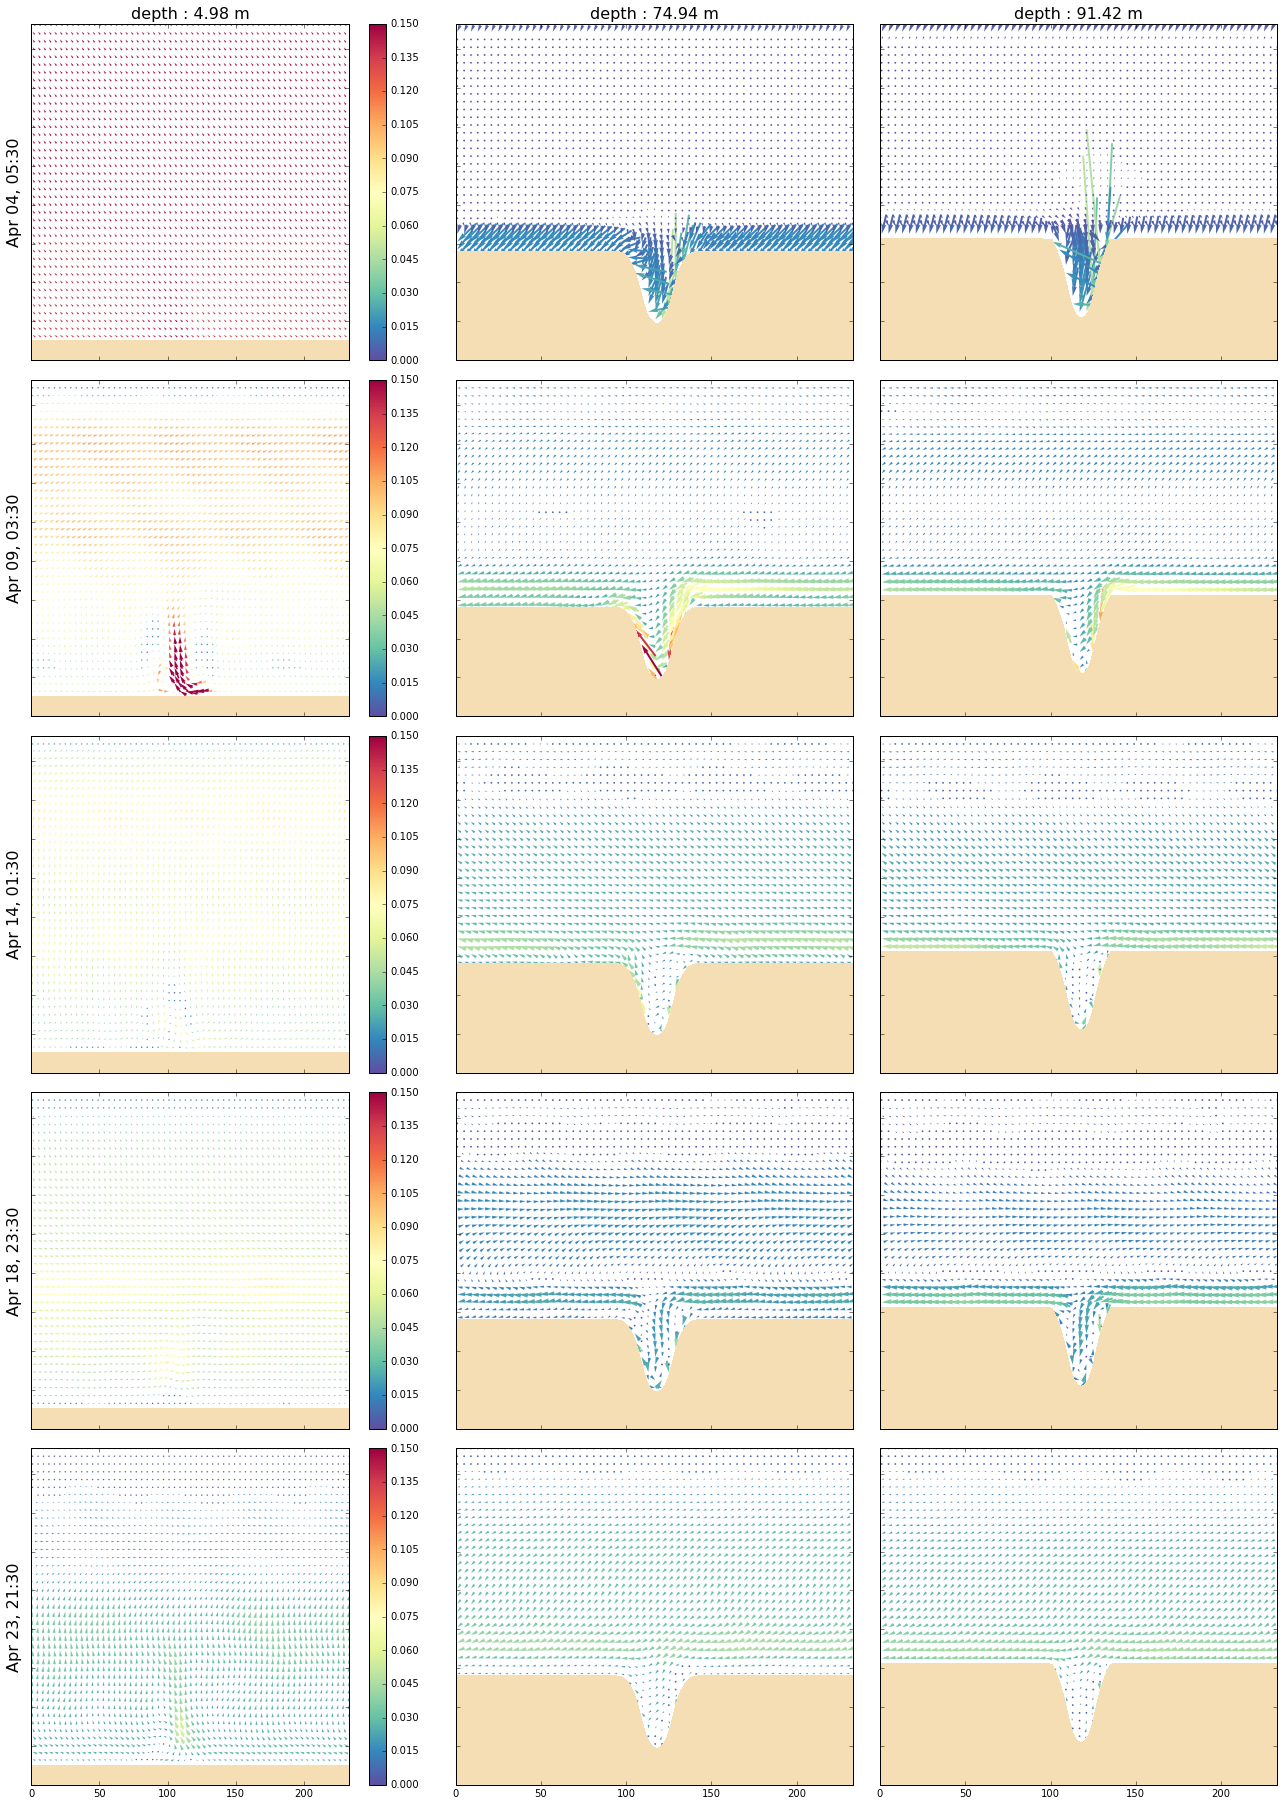

In [3]:
depth_inds = [0, 6, 7]
time_inds = np.linspace(5, 477, 5)
fig = functions_profiles.plot_quiver_stories(U, V, grid, depth_inds, time_inds, 0.15, 4, bathy_file)

In [4]:
def plot_incoming_speeds(U_vel, V_vel, gridT, depth_ind, time_inds, time_shot, max_vel, bathy_file, utau):
    
    # definitions
    x_point = 160; y_min = 55; y_max = 80
    dep_m = round(gridT['deptht'][:][depth_ind],2)

    fig = plt.figure(figsize=(20,12))
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,1,2)
    fig.tight_layout()
    
    # find the speed at a depth and time to create pcolor
    x_slice, y_slice, u_nstg, v_nstg, speeds = functions_profiles.get_speeds(U_vel, V_vel, depth_ind, time_shot, 1)
    p = ax1.pcolor(speeds, vmin=0, vmax=max_vel, cmap='Spectral_r')
    viz_tools.plot_land_mask(ax1, bathy_file,'grid', dep_m, None, None, 'wheat')
    timestamp = nc_tools.timestamp(gridT, time_shot).format('MMM DD, HH:mm')
    ax1.set_title('Domain flow speeds on ' + timestamp + ' (' + str(dep_m) + ' m)')
    fig.colorbar(p, ax=ax1); ax1.set_ylabel('y index'); ax1.set_xlabel('x index')
    
    # define and plot the transect
    y_line = np.arange(y_min,y_max)
    x_line = np.ones_like(y_line)*x_point
    ax1.plot(x_line, y_line, linewidth=5, c='k', label='transect'); ax1.legend(loc=1)
    
    # convert all time indices into datetimes and convert these into matplotlib version
    dates = []
    utau_new = np.zeros(len(time_inds))
    for i in np.arange(len(time_inds)):
        dates.append(nc_tools.get_datetimes(grid)[time_inds[i]])
        utau_new[i] = utau[time_inds[i],-1,-1]
    dates = matplotlib.dates.date2num(dates)
    
    date_shot0 = nc_tools.get_datetimes(grid)[time_shot]
    date_shot = matplotlib.dates.date2num(date_shot0)
    
    # plot the wind stress
    ax2.plot_date(dates, utau_new, c='k', lw=3, markersize=8)
    ax2.axvline(date_shot, c = 'dodgerblue', lw=3, label='')
    ax2.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    ax2.legend(loc=1)#;ax2.invert_yaxis()
    ax2.set_ylim([0.02, -0.16])
    ax2.set_title('Wind stress profile'); ax2.set_xlabel('time steps'); ax2.set_ylabel('wind stress [Nm$^{-2}$]')

    # crop the velocities for the transect
    U_vel = U_vel[:, :, y_min:y_max, x_point-1:x_point+1]
    V_vel = V_vel[:, :, y_min:y_max, x_point-1:x_point+1]
    
    # get the speeds along the transect at every time index and then store in a matrix
    len_y = len(y_line)-1
    speeds_all = np.zeros([len_y,len(time_inds)])
    for time_ind, m in zip(time_inds, np.arange(len(time_inds))):
        x_slice, y_slice, u_nstg, v_nstg, speeds = functions_profiles.get_speeds(U_vel, V_vel, depth_ind, time_ind, 1)
        for n in zip(np.arange(len_y)):
            speeds_all[n, m] = speeds[n, :]
    
    # define colors for every point along the transect
    cms = np.linspace(0, 1, len_y)
    cs = [ cm.jet(x) for x in cms]
    
    # moved from here
    
    # plot speeds at every point and use plot_date to use matplotlib's datetime 
    for n in np.arange(len_y):
        ax3.plot_date(dates, speeds_all[n, :], color = cs[n], linestyle='-', label = str(y_line[n]))
    ax3.axvline(date_shot, c = 'dodgerblue', lw=3, label='')    
    ax3.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    ax3.legend(ncol=12, loc=1)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Speed [m/s]')
    ax3.set_title('Speed of the incoming flow different points along the transect')
    fig.subplots_adjust(hspace=.3)
    
    plt.show()
    return fig

# 91 m depth (plotted every 25 hours)

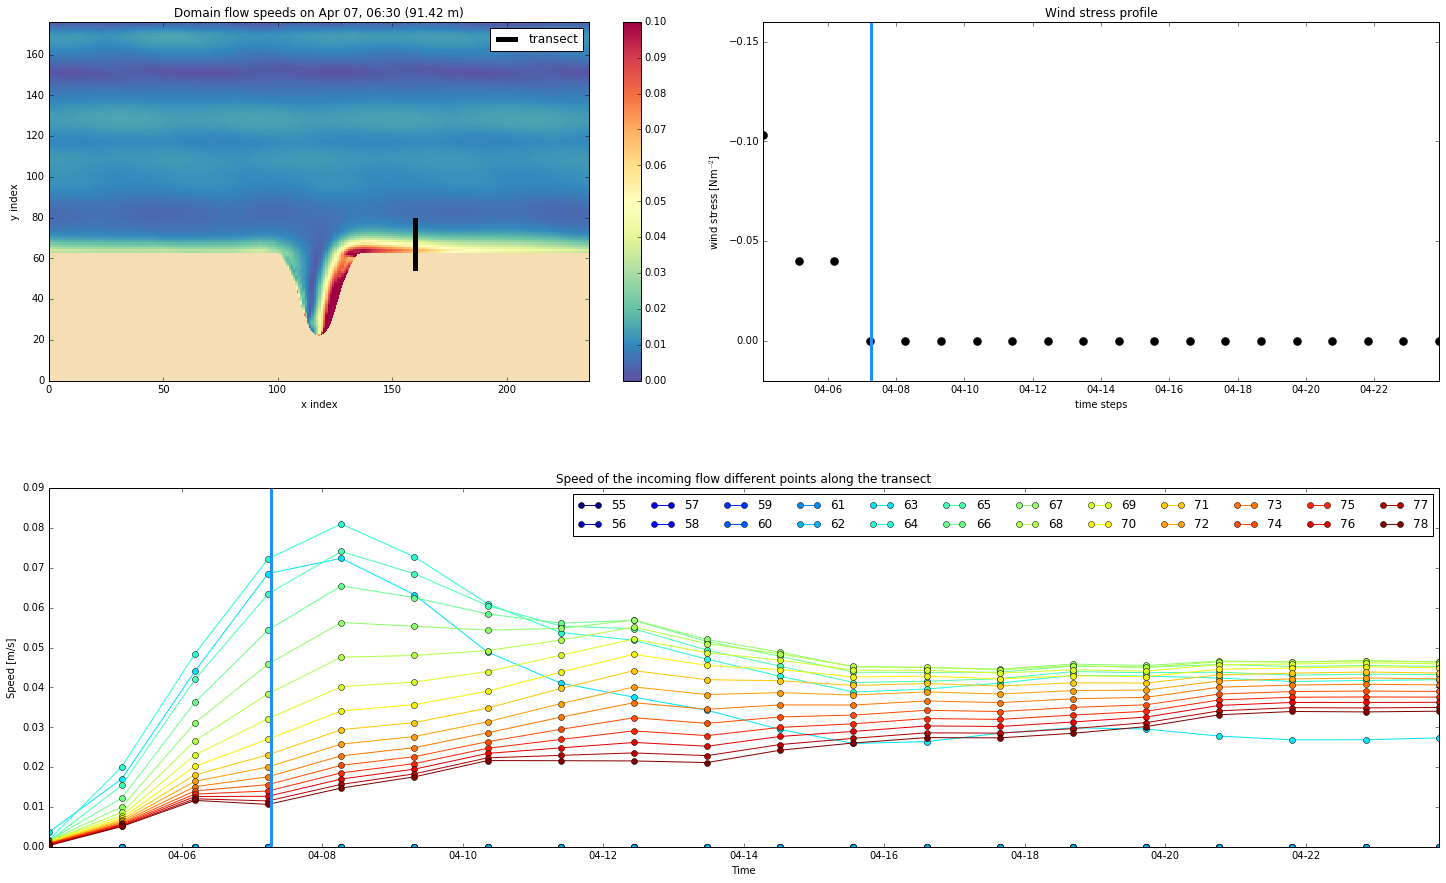

In [5]:
time_shot=3.25*24
time_inds = np.arange(2,479,25)
fig = plot_incoming_speeds(U, V, grid, 7, time_inds, time_shot, 0.1, bathy_file, utau)

# 91 m depth (plotted every 14 hours)

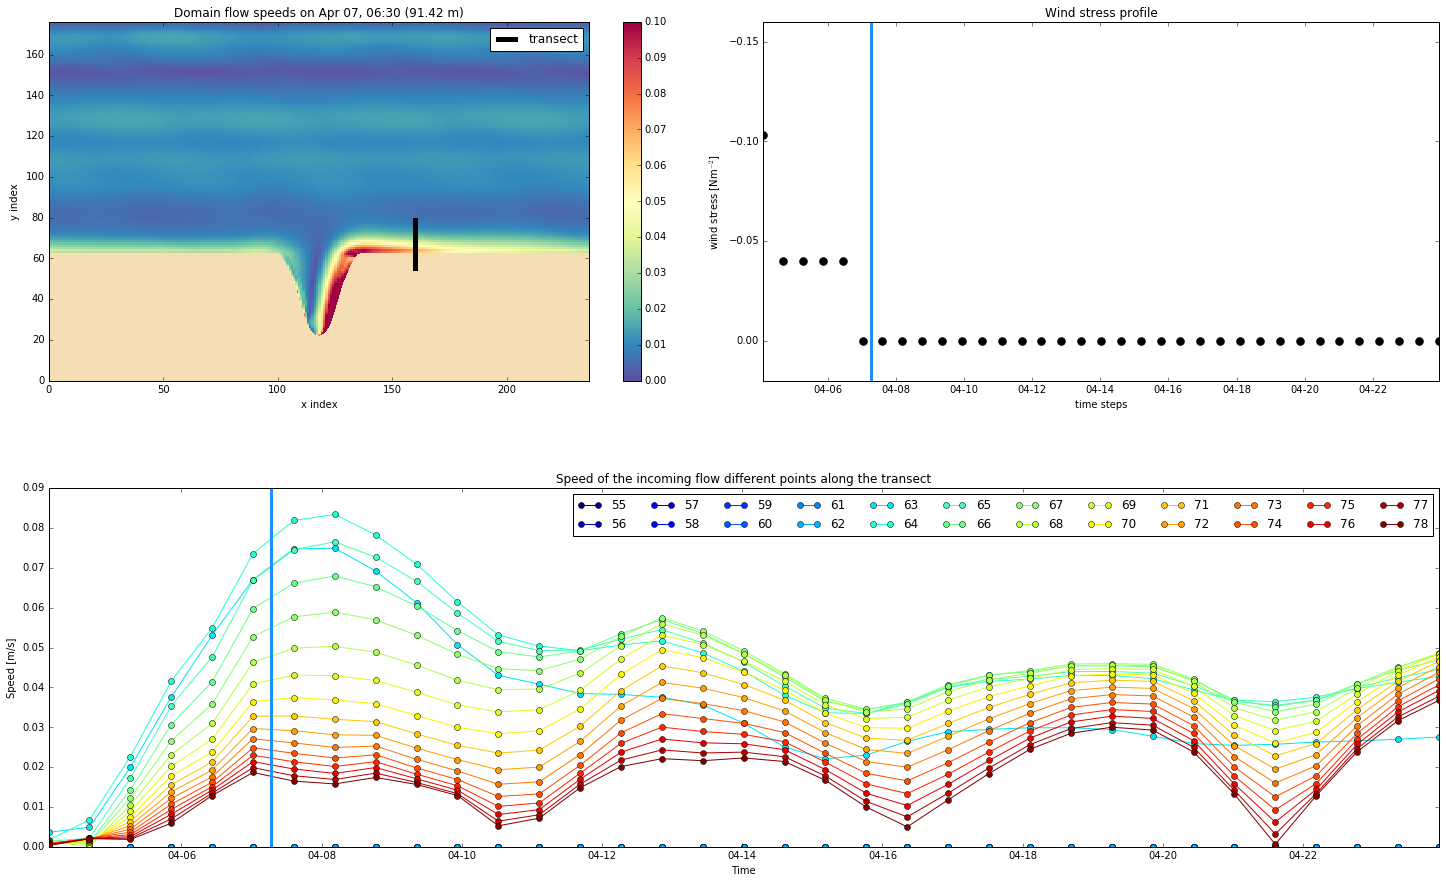

In [6]:
time_shot=3.25*24
time_inds = np.arange(2,479,14)
fig = plot_incoming_speeds(U, V, grid, 7, time_inds, time_shot, 0.1, bathy_file, utau)

# 91 m depth (plotted every 3 hours)

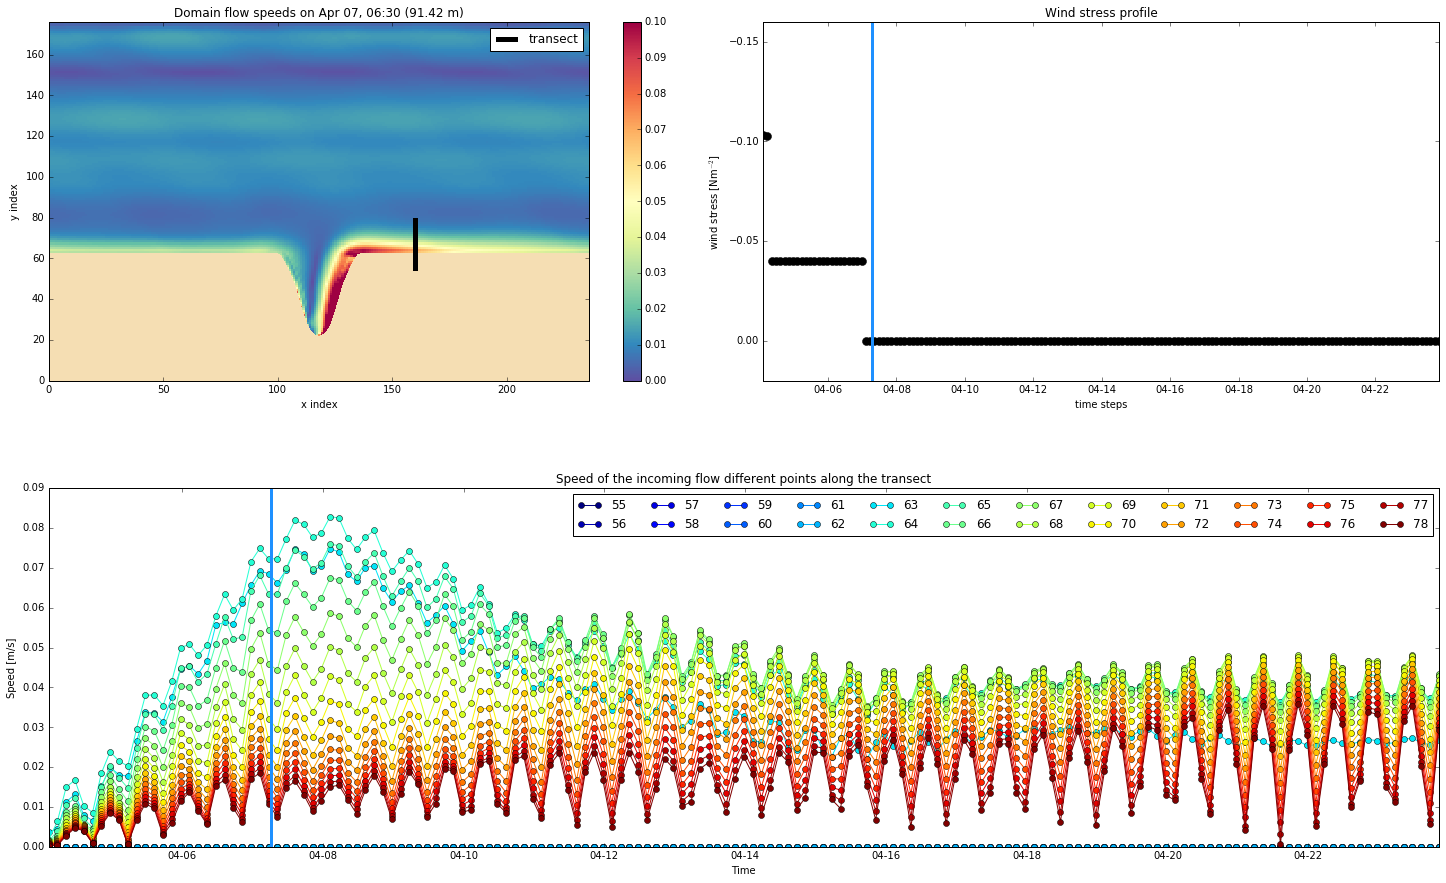

In [7]:
time_shot=3.25*24
time_inds = np.arange(2,479,3)
fig = plot_incoming_speeds(U, V, grid, 7, time_inds, time_shot, 0.1, bathy_file, utau)

# 74 m depth (plotted every 25 hours)

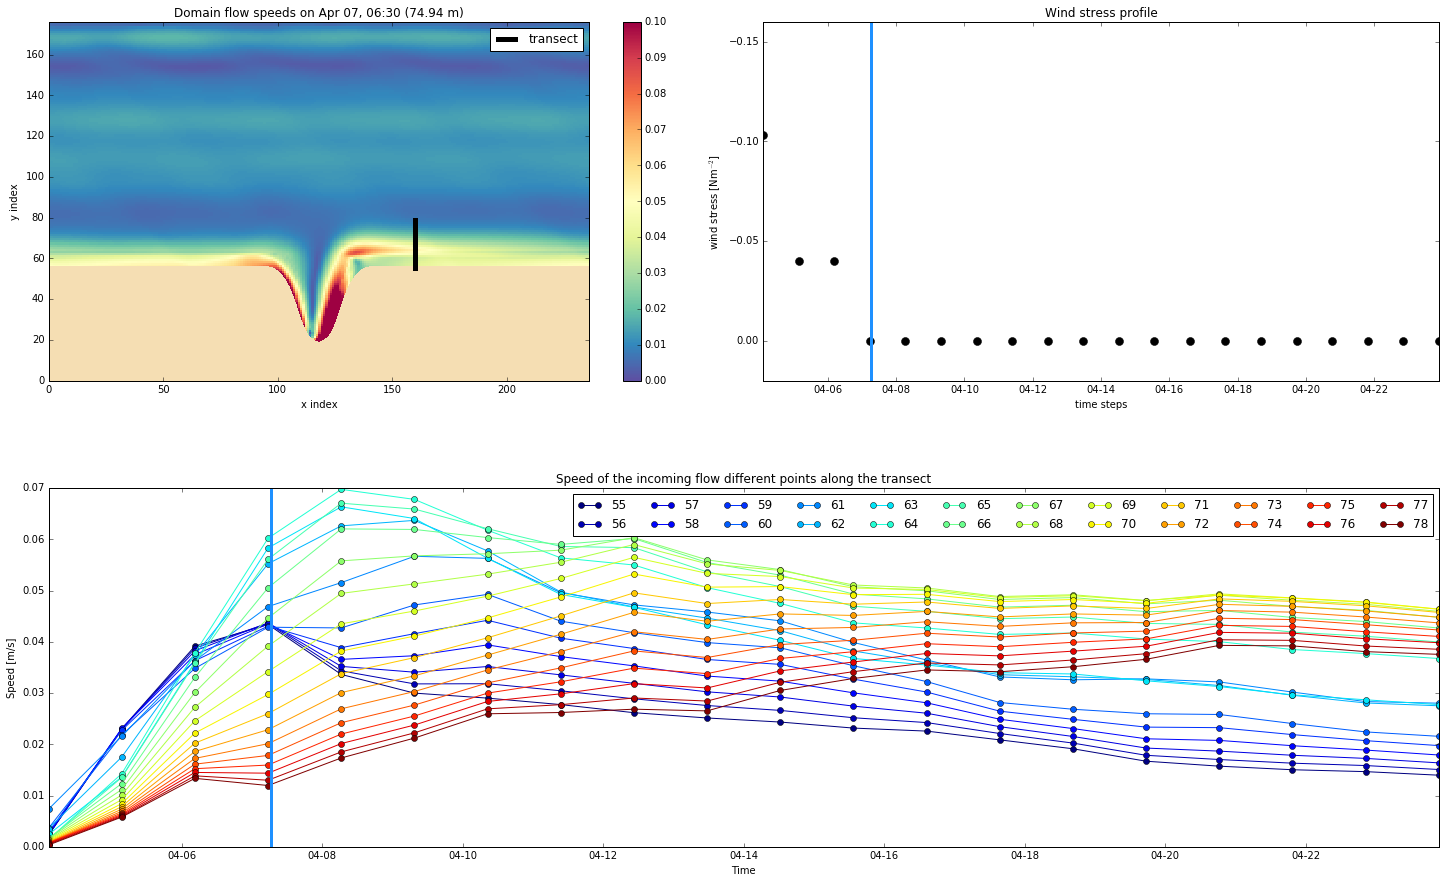

In [8]:
time_shot=3.25*24
time_inds = np.arange(2,479,25)
fig = plot_incoming_speeds(U, V, grid, 6, time_inds, time_shot, 0.1, bathy_file, utau)

# 111 m depth (plotted every 25 hours)

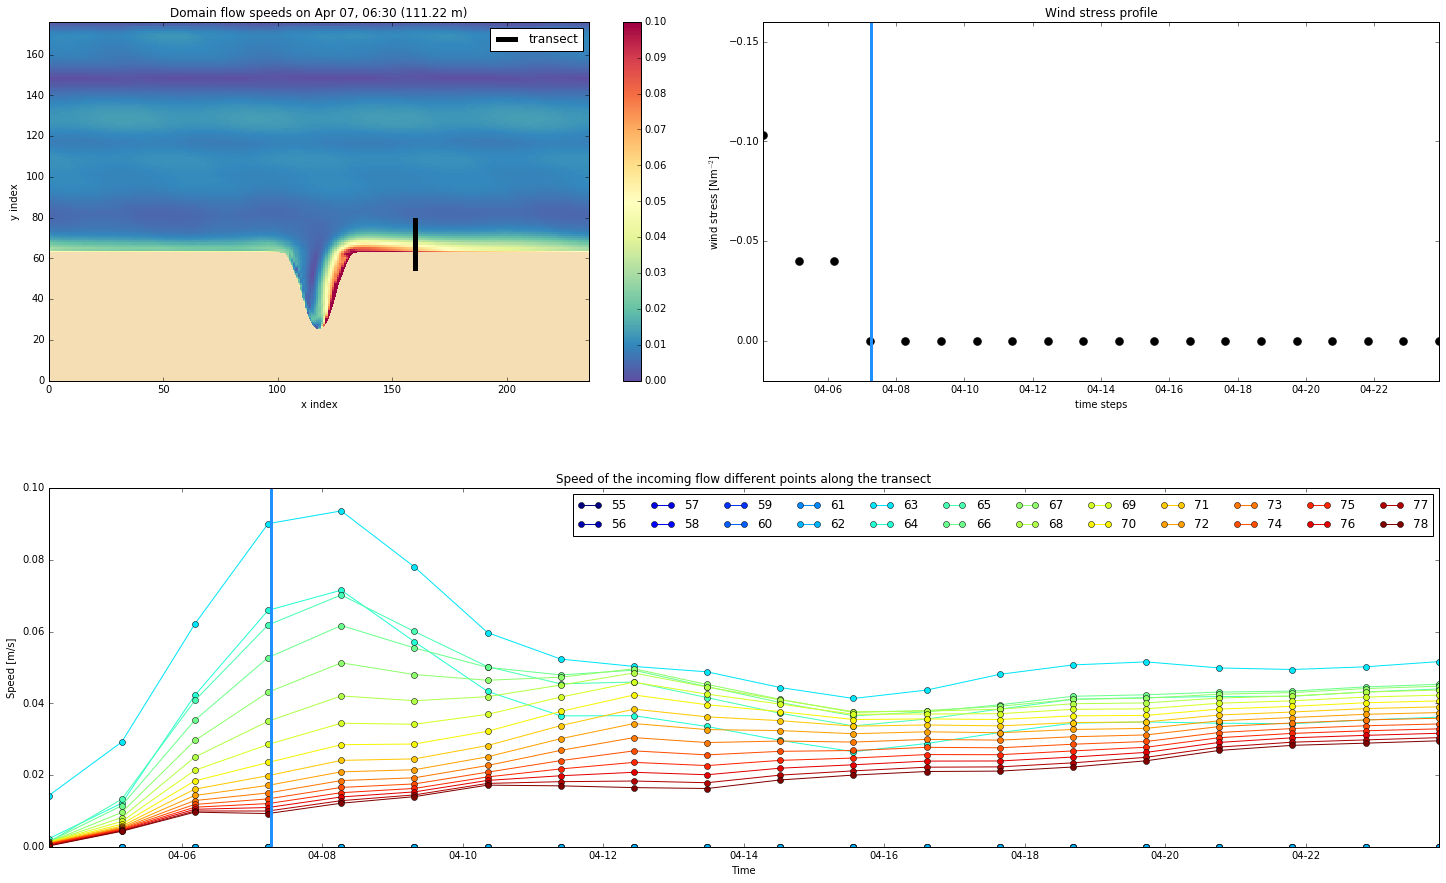

In [9]:
time_shot=3.25*24
time_inds = np.arange(2,479,25)
fig = plot_incoming_speeds(U, V, grid, 8, time_inds, time_shot, 0.1, bathy_file, utau)

In [14]:
ts_data_deep = sio.loadmat('../data/for_stratification/canyonTSdata2.mat')
i_can, i_ref = 0, 4
sal_can = ts_data_deep['salcanyon2'][:, i_can]
sal_ref = ts_data_deep['salcanyon2'][:, i_ref]
dep_can = ts_data_deep['depthcanyon2'][:, i_can]*-1
dep_ref = ts_data_deep['depthcanyon2'][:, i_ref]*-1

In [15]:
def get_inds_max_depth(time_shot): 
    inds_max_depth = np.zeros([sal.shape[2],sal.shape[3]])
    for j in range(sal.shape[2]):
        for i in range(sal.shape[3]):
            sal_column = sal[time_shot, :, j, i]
            try:
                ind = np.where(sal_column == np.nanmax(sal_column))[0][0]
            except IndexError:
                ind = 0
            inds_max_depth[j, i] = ind
    return inds_max_depth

def get_unique_values(inds_max_depth):
    depth_ind_rim = 7
    x_ind_rim_depth = np.where(inds_max_depth == depth_ind_rim)[1]
    y_ind_rim_depth = np.where(inds_max_depth == depth_ind_rim)[0]

    unique_x_values = np.unique(x_ind_rim_depth)
    ys_for_unique_x_values = np.zeros_like(unique_x_values)
    for n in range(len(ys_for_unique_x_values)):
        same_x_value = unique_x_values[n]
        inds_same_x_value = [i for i, x in enumerate(x_ind_rim_depth) if x == same_x_value]
        ys_for_same_x_value = (y_ind_rim_depth[inds_same_x_value])
        max_y_value = ys_for_same_x_value.min()
        ys_for_unique_x_values[n] = max_y_value
    return ys_for_unique_x_values, unique_x_values, x_ind_rim_depth, y_ind_rim_depth

def get_sal_profiles_rim(ys_for_unique_x_values, unique_x_values):
    sal_profiles_rim = ma.masked_all([30, len(unique_x_values)])
    for y, x, n in zip(ys_for_unique_x_values, unique_x_values, np.arange(len(unique_x_values))):
        this_profile = sal[time_shot, :, y, x]
        sal_profiles_rim[:, n] = this_profile
    return sal_profiles_rim

In [18]:
def calculate_depth_change(sal_profiles_rim, ind_dep_above_rim):
    depth_change = np.zeros(sal_profiles_rim.shape[1])
    for unique_point in range(len(depth_change)):
        sal_result = sal_profiles_rim[ind_dep_above_rim, unique_point]
        ind_result_nearest_ref = min(range(len(sal_ref)), key=lambda i: abs(sal_ref[i]-sal_result))
        d_ref = dep_ref[ind_result_nearest_ref]
        d_new = grid['deptht'][ind_dep_above_rim]
        depth_change[unique_point] = d_ref - d_new
    return depth_change, d_new

def plot_depth_change(fig, axA, axB, depth_change, d_new):
    vmax, vmin = 50, -50
    axA.plot(depth_change, c = 'gray', lw=2)
    axA.scatter(np.arange(len(depth_change)), depth_change, c=depth_change, cmap = cmo.cm.curl, 
                vmin=vmin, vmax=vmax, s=100)
    axA.text(43, 50, 'up', fontsize = 12, bbox={'facecolor':'white', 'pad':4})
    axA.text(43, -10, 'down', fontsize = 12, bbox={'facecolor':'white', 'pad':4})
    axA.axhline(0, c='k', lw=2); axA.grid(); axA.set_ylim([-30, 60])
    axA.set_title('Depth change at points along rim [' + str(round(d_new,1))+ 'm]')

    s = axB.scatter(unique_x_values, ys_for_unique_x_values, c=depth_change, cmap = cmo.cm.curl, 
                    vmin=vmin, vmax=vmax, s=150)
    fig.colorbar(s, ax=axB)
    axB.set_title('Depth change at points along rim [' + str(round(d_new,1))+ 'm]')
    return axA, axB

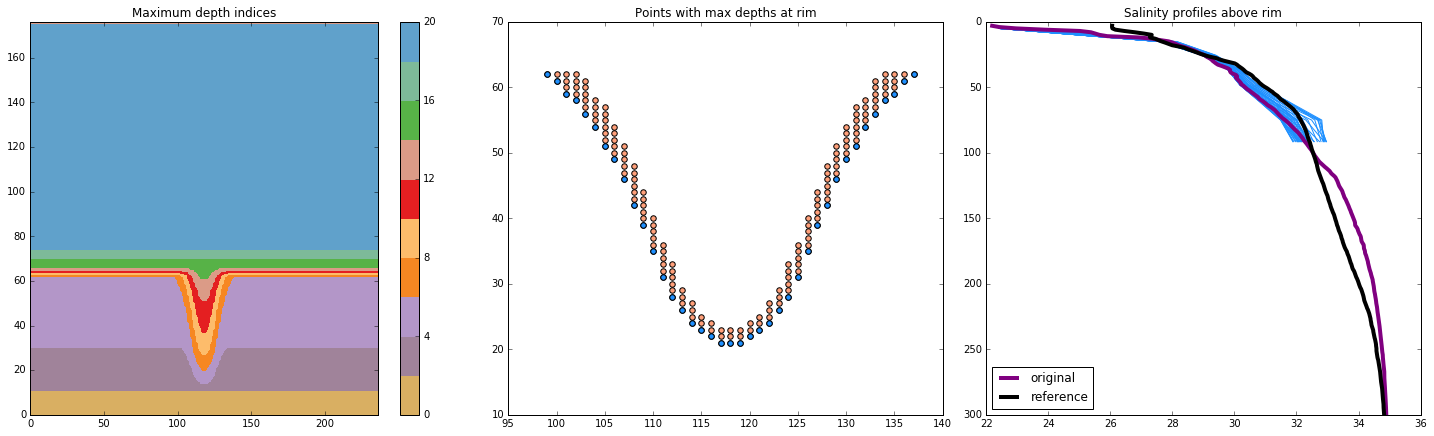

In [21]:
time_shot=3.25*24
inds_max_depth = get_inds_max_depth(time_shot)
ys_for_unique_x_values, unique_x_values, x_ind_rim_depth, y_ind_rim_depth = get_unique_values(inds_max_depth)
sal_profiles_rim = get_sal_profiles_rim(ys_for_unique_x_values, unique_x_values)

#------------------------------------------------------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,6))
fig.tight_layout(); fig.subplots_adjust(hspace=.3, wspace=.1)
p1 = ax1.contourf(inds_max_depth, cmap = 'Paired_r', levels=np.arange(22)[::2])
fig.colorbar(p1, ax=ax1); ax1.set_title('Maximum depth indices')

ax2.scatter(x_ind_rim_depth, y_ind_rim_depth, s = 30, c = 'lightsalmon')
ax2.scatter(unique_x_values, ys_for_unique_x_values, s = 30, c='dodgerblue')
ax2.set_title('Points with max depths at rim')

ax3.plot(sal_profiles_rim, grid['deptht'], c='dodgerblue', label='')
ax3.plot(sal_can, dep_can, lw = 2, c='purple', linewidth=4, label = 'original')
ax3.plot(sal_ref, dep_ref, lw = 2, c='k', linewidth=4, label = 'reference')
ax3.set_ylim([300,0]); ax3.legend(loc=3)
ax3.set_title('Salinity profiles above rim')

<function matplotlib.pyplot.show>

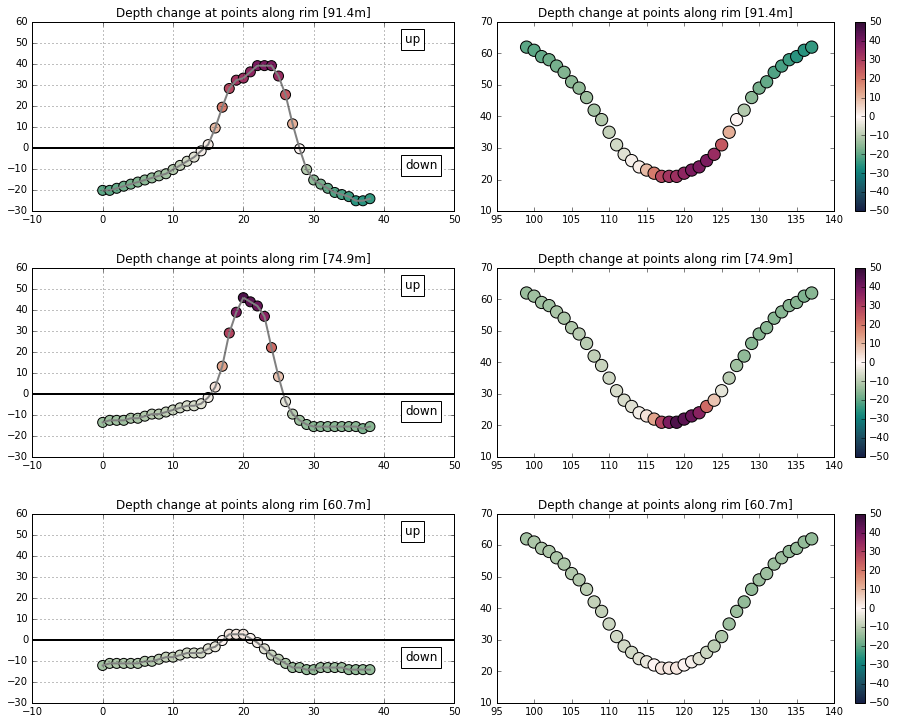

In [22]:
depth_ind_rim = 7
ind_dep_above_rim = depth_ind_rim

fig, ([ax4, ax5], [ax6, ax7], [ax8, ax9]) = plt.subplots(3, 2, figsize = (13,10))
fig.tight_layout(); fig.subplots_adjust(hspace=.3, wspace=.1)

depth_change, d_new = calculate_depth_change(sal_profiles_rim, ind_dep_above_rim)
ax4, ax5 = plot_depth_change(fig, ax4, ax5, depth_change, d_new)

depth_change, d_new = calculate_depth_change(sal_profiles_rim, ind_dep_above_rim-1)
ax6, ax7 = plot_depth_change(fig, ax6, ax7, depth_change, d_new)

depth_change, d_new = calculate_depth_change(sal_profiles_rim, ind_dep_above_rim-2)
ax8, ax9 = plot_depth_change(fig, ax8, ax9, depth_change, d_new)

plt.show

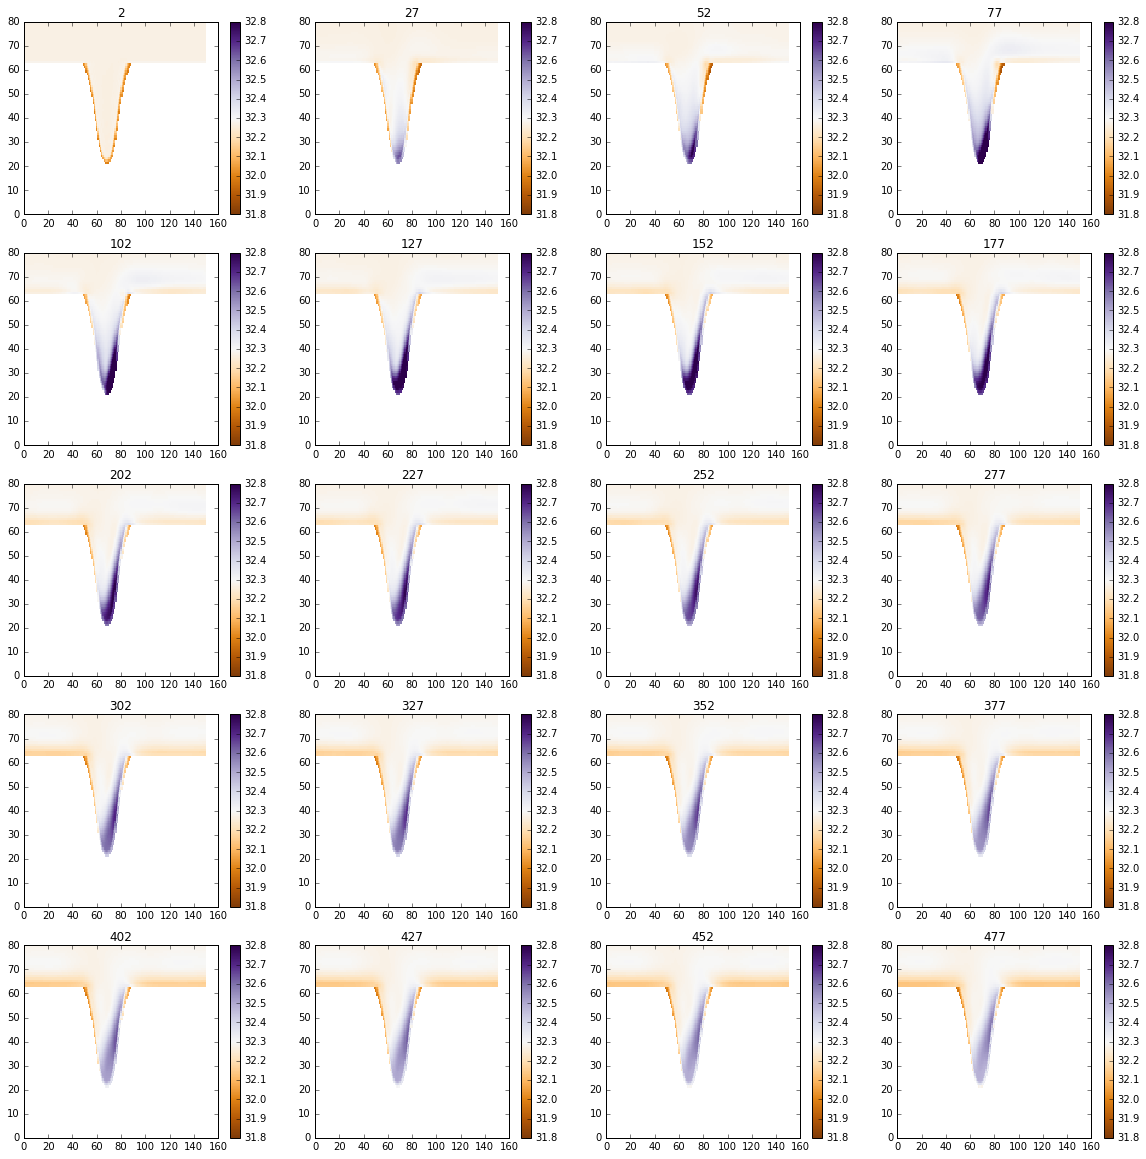

In [23]:
fig, axs = plt.subplots(5,4,figsize=(20,20))
for ax, time_ind in zip(axs.ravel(), time_inds):
    c = ax.pcolor(sal[time_ind, depth_ind_rim, :80, 50:200], cmap='PuOr', vmin=31.8, vmax=32.8)
    fig.colorbar(c, ax=ax)
    ax.set_title(str(time_ind))

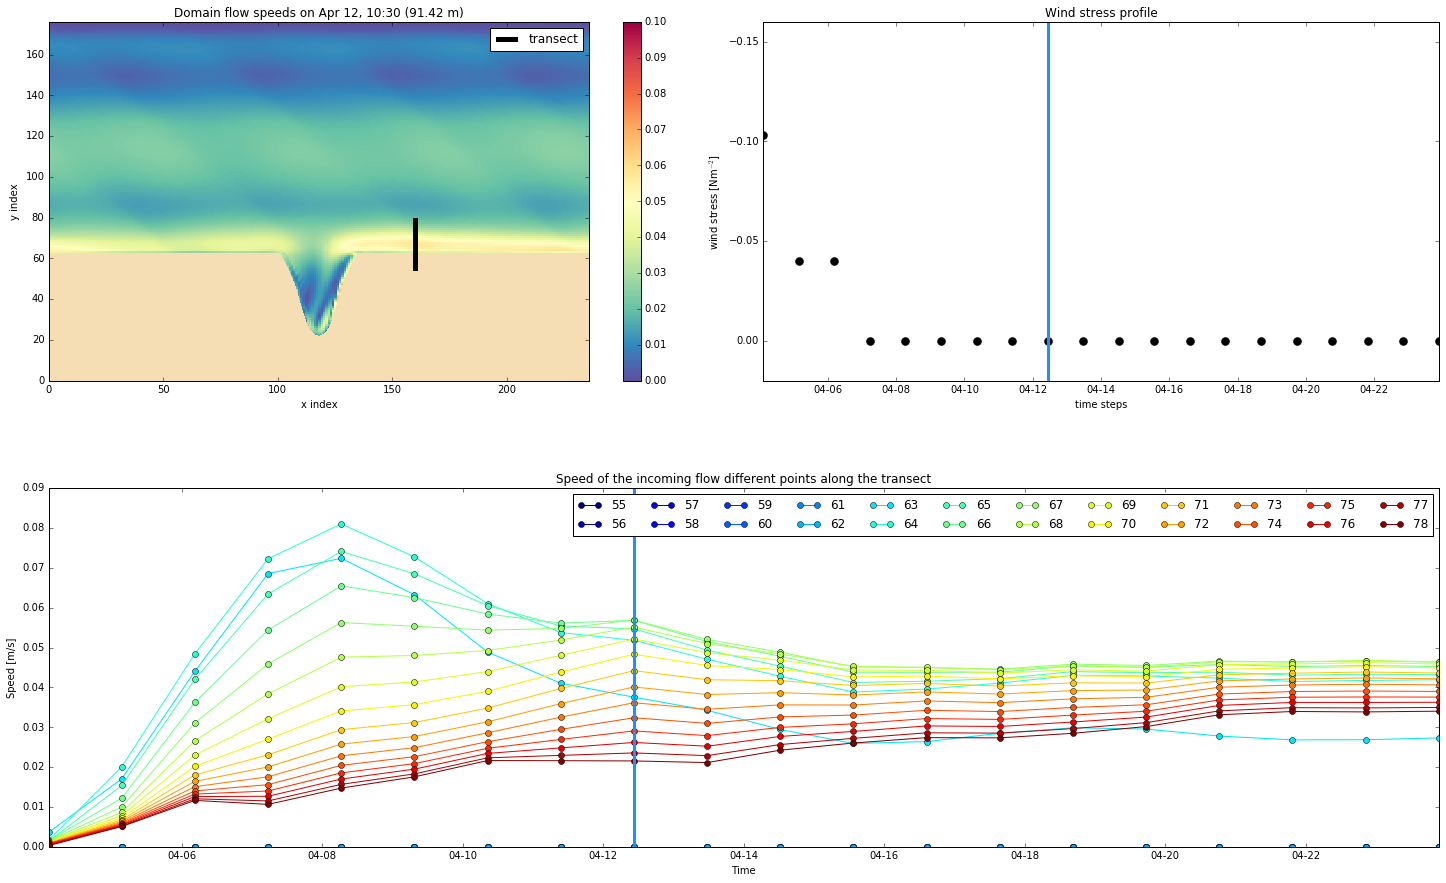

In [24]:
time_shot=202
time_inds = np.arange(2,479,25)
fig = plot_incoming_speeds(U, V, grid, 7, time_inds, time_shot, 0.1, bathy_file, utau)

<function matplotlib.pyplot.show>

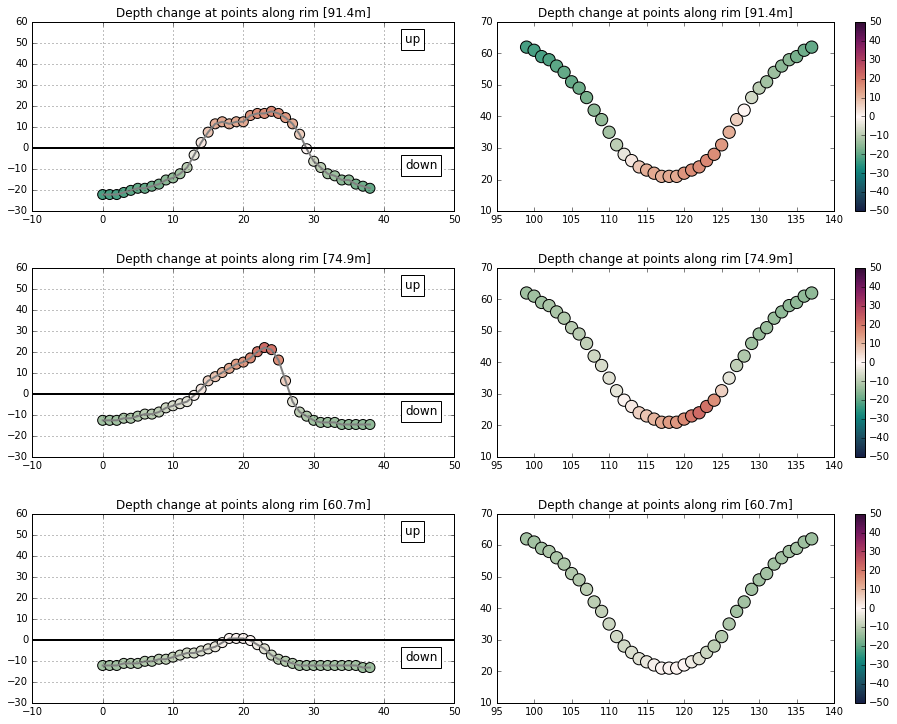

In [25]:
inds_max_depth = get_inds_max_depth(time_shot)
ys_for_unique_x_values, unique_x_values, x_ind_rim_depth, y_ind_rim_depth = get_unique_values(inds_max_depth)
sal_profiles_rim = get_sal_profiles_rim(ys_for_unique_x_values, unique_x_values)

ind_dep_above_rim = depth_ind_rim

fig, ([ax4, ax5], [ax6, ax7], [ax8, ax9]) = plt.subplots(3, 2, figsize = (13,10))
fig.tight_layout(); fig.subplots_adjust(hspace=.3, wspace=.1)

depth_change, d_new = calculate_depth_change(sal_profiles_rim, ind_dep_above_rim)
ax4, ax5 = plot_depth_change(fig, ax4, ax5, depth_change, d_new)

depth_change, d_new = calculate_depth_change(sal_profiles_rim, ind_dep_above_rim-1)
ax6, ax7 = plot_depth_change(fig, ax6, ax7, depth_change, d_new)

depth_change, d_new = calculate_depth_change(sal_profiles_rim, ind_dep_above_rim-2)
ax8, ax9 = plot_depth_change(fig, ax8, ax9, depth_change, d_new)

plt.show

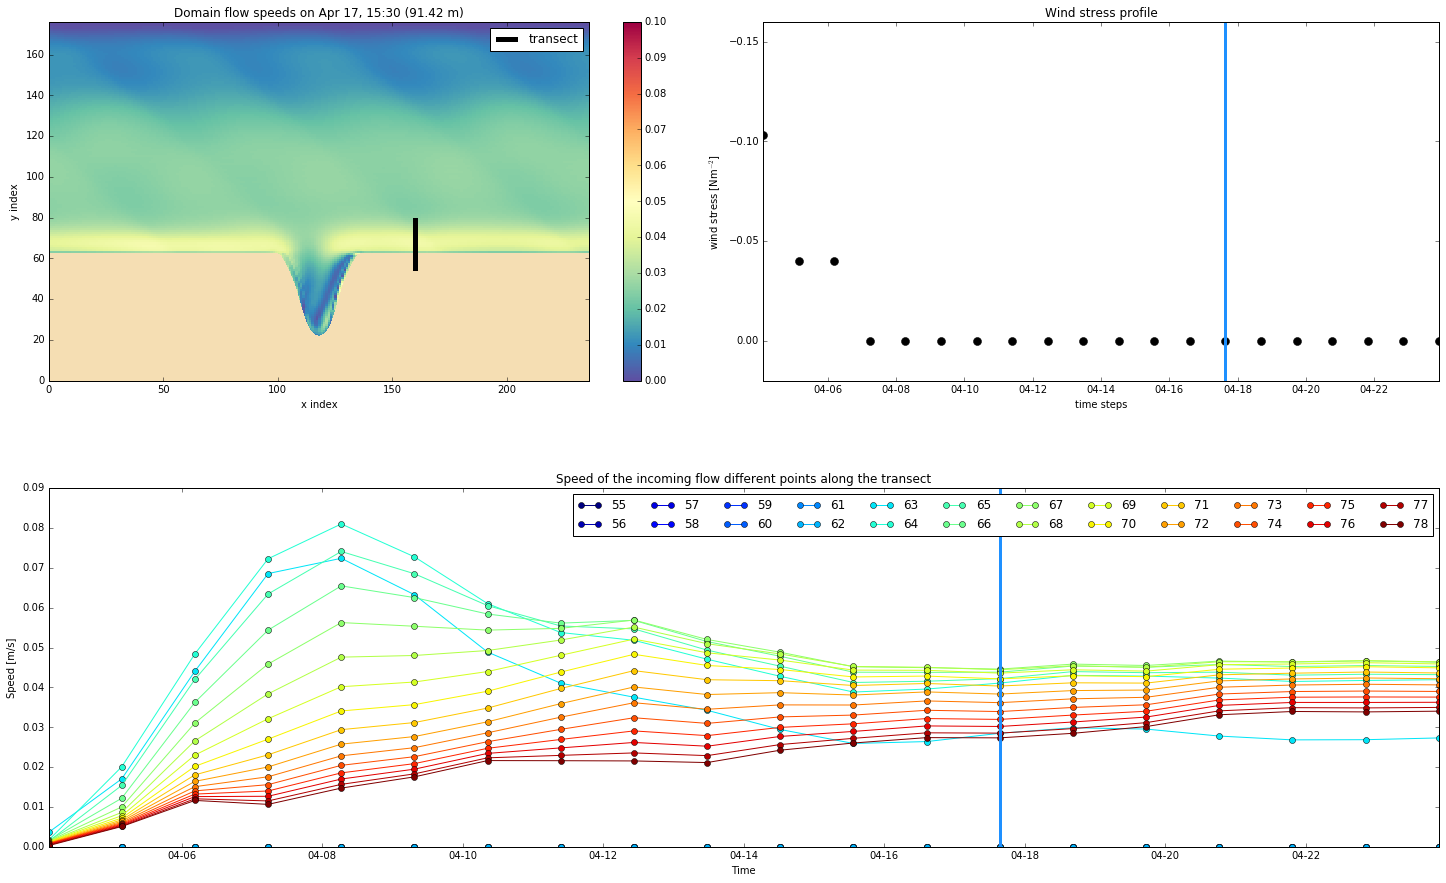

In [26]:
time_shot=327
time_inds = np.arange(2,479,25)
fig = plot_incoming_speeds(U, V, grid, 7, time_inds, time_shot, 0.1, bathy_file, utau)

<function matplotlib.pyplot.show>

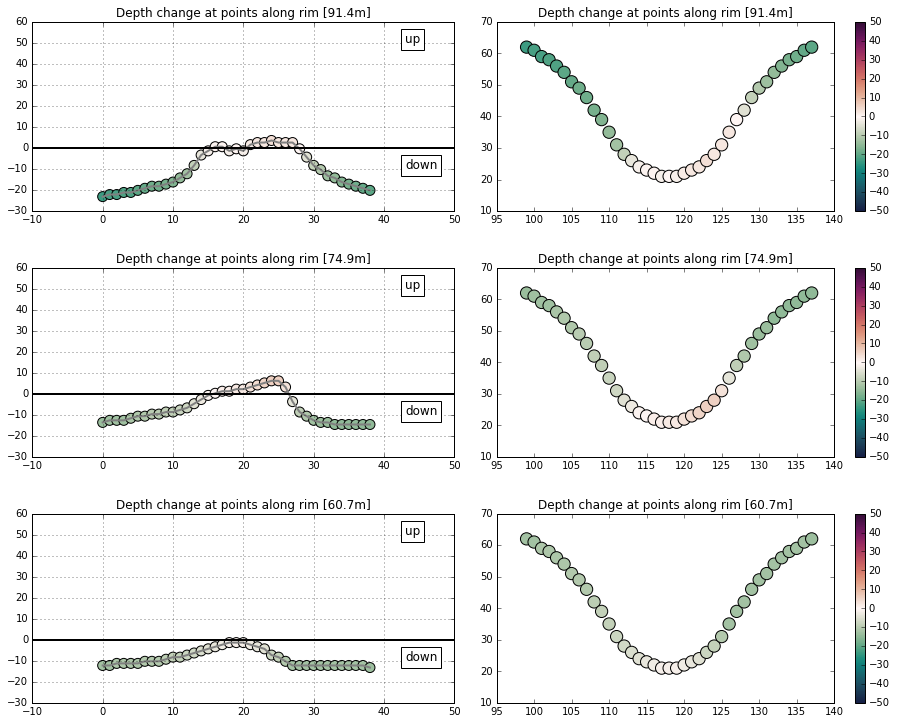

In [27]:
inds_max_depth = get_inds_max_depth(time_shot)
ys_for_unique_x_values, unique_x_values, x_ind_rim_depth, y_ind_rim_depth = get_unique_values(inds_max_depth)
sal_profiles_rim = get_sal_profiles_rim(ys_for_unique_x_values, unique_x_values)

ind_dep_above_rim = depth_ind_rim

fig, ([ax4, ax5], [ax6, ax7], [ax8, ax9]) = plt.subplots(3, 2, figsize = (13,10))
fig.tight_layout(); fig.subplots_adjust(hspace=.3, wspace=.1)

depth_change, d_new = calculate_depth_change(sal_profiles_rim, ind_dep_above_rim)
ax4, ax5 = plot_depth_change(fig, ax4, ax5, depth_change, d_new)

depth_change, d_new = calculate_depth_change(sal_profiles_rim, ind_dep_above_rim-1)
ax6, ax7 = plot_depth_change(fig, ax6, ax7, depth_change, d_new)

depth_change, d_new = calculate_depth_change(sal_profiles_rim, ind_dep_above_rim-2)
ax8, ax9 = plot_depth_change(fig, ax8, ax9, depth_change, d_new)

plt.show